In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import emcee

In [2]:
font = {'size'   : 15, 'family':'sans-serif'}
axislabelfontsize='large'
matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True)

In [3]:
def remove_outliers(sample, walker_out, ndim):
    '''remove outliers
    Args:
        sample: sample in the form (i, j, k)
                i: steps, j:walkers, k:dimensions.
        walker_out: label (number) of the walkers with outlier.
        ndim: number of dimensions.
    Returns:
        Flat chain without outliers (GetDist format)
    '''
    
    sampleT = sample.T
    sampleT_cut = np.delete(sampleT, walker_out, axis = 1)
    sample_cut = sampleT_cut.T
    
    walkers = len(sample_cut[0][:])
    sample_cut_flat = np.zeros((len(sample_cut)*walkers, ndim))
    
    for ii in range(ndim):
        sample_cut_flat[:, ii] = sample_cut[:,:,ii].flatten()
        
    return {'sample_cut': sample_cut, 'sample_cut_flat':sample_cut_flat}

In [4]:
def read_chains_backends(chainfiles):
    all_chains = []
    all_best_samples = []
    all_log_probs = []

    for chainfile in chainfiles:
        reader = emcee.backends.HDFBackend(chainfile)
        samples_input = reader.get_chain()
        burnin = int(len(samples_input) * 0.45)
        
        chain = reader.get_chain(discard=burnin, flat=True, thin=1)
        all_chains.append(chain)

        #log_prob_samples = reader.get_log_prob(discard=burnin, flat=True, thin=1)
        #bestid = np.argmax(log_prob_samples)
        #best_sample = copy.copy(samples_input[bestid])
        #all_best_samples.append(best_sample)
        #all_log_probs.append(log_prob_samples)

    return np.array(all_chains)[0]

In [5]:
def get_stats_chains(chains, percentile=0.6827):
    """
    Calculate statistics for each chain in a list of chains.

    Parameters:
    chains (list of numpy arrays): List of chains, where each chain is a 2D numpy array.
    percentile (float): Desired percentile for calculating sigma ranges. Default is 0.6827.

    Returns:
    list of dictionaries: List containing dictionaries with calculated statistics for each chain.
    """
    
    results = []

    for chain in chains:
        n_params = chain.shape[1]
        stats = {'median': [], 'sigma-': [], 'sigma+': [], 'mean': [], 'sigma': []}

        for i in range(n_params):
            data = chain[:, i]
            nb_x = len(data)
            ind_inf = int(np.floor(nb_x * (0.5 - percentile/2)))
            ind_sup = int(np.ceil(nb_x * (0.5 + percentile/2)))
            ind_med = int(np.round(nb_x * 0.5))
            data_sorted = np.sort(data)
            stats['median'].append(data_sorted[ind_med])
            stats['sigma-'].append(data_sorted[ind_inf] - data_sorted[ind_med])
            stats['sigma+'].append(data_sorted[ind_sup] - data_sorted[ind_med])
            stats['mean'].append(np.mean(data))
            stats['sigma'].append(np.std(data))

        results.append(stats)

    return results

In [6]:
def plot_triangular_chains(chains_and_labels, filled, contour_ls, contour_lws,
                           legend_labels, contour_colors, markers, params_to_show=None,
                           title=None, fontsize_title=None, title_x=None, title_y=None,
                           save_path=None, smoothing=False, params_ranges=None):
    '''
    Generate a triangular plot for multiple chains of samples.

    Args:
        chains_and_labels (list of tuples): List of tuples where each tuple contains a numpy array representing the sample chain and its corresponding labels.
        filled (list): List of True or False for filled contours or not.
        contour_ls (list): List of line styles: '-', '--', '-.', ':'.
        contour_lws (list): List of line widths.
        legend_labels (list): Labels for the legends of each chain.
        contour_colors (list): List of colors to be used.
        markers (list): List of markers for each chain.
        params_to_show (list, optional): List of parameters to be shown in the plot. Default is None.
        title (str, optional): Title of the plot. Default is None.
        fontsize_title (float, optional): Font size for the plot title.
        title_x (float, optional): x-coordinate of the plot title.
        title_y (float, optional): y-coordinate of the plot title.
        save_path (str, optional): Path to save the plot image. Default is None.
        smoothing (bool, optional): Whether to apply smoothing to the samples. Default is False.
        params_ranges (dict, optional): Dictionary with parameter names as keys and corresponding ranges as values.

    Returns:
        A beautiful triangular plot.
    '''

    # Create MCSamples instances for each chain and its labels
    samples = []
    for chain, labels in chains_and_labels:
        ranges = {}
        if params_ranges:
            for param, param_range in params_ranges.items():
                ranges[param] = param_range
        sample_instance = MCSamples(samples=chain, names=labels, ranges=ranges)
        samples.append(sample_instance)

    # If params_to_show is not provided, show all parameters
    if params_to_show is None:
        params_to_show = [labels for _, labels in chains_and_labels]

    # Apply smoothing if specified
    if smoothing:
        samples_smooth = [s.copy(settings={'mult_bias_correction_order': 1,
                                           'smooth_scale_2D': 0.7,
                                           'smooth_scale_1D': 0.7}) for s in samples]
    else:
        samples_smooth = samples

    # Plot settings
    g = plots.get_subplot_plotter()
    g.settings.figure_legend_frame = False
    g.settings.alpha_filled_add = 0.8
    g.settings.legend_fontsize = 18
    g.settings.axes_labelsize = 19
    g.settings.axes_fontsize = 16
    g.settings.axis_marker_color = 'k'
    g.settings.axis_marker_lw = 1.2

    # Generate the triangular plot with selected parameters
    g.triangle_plot(samples_smooth, params_to_show,
                    filled=filled,
                    contour_ls=contour_ls,
                    contour_lws=contour_lws,
                    legend_labels=legend_labels,
                    legend_loc='upper right',
                    contour_colors=contour_colors,
                    markers=markers,
                    line_args=[{'ls': ls, 'lw': lw, 'color': color} for ls, lw, color in zip(contour_ls, contour_lws, contour_colors)])

    # Add title to the plot
    if title:
        plt.suptitle(title, fontsize=fontsize_title, x=title_x, y=title_y)

    # Save the plot to the specified path
    if save_path:
        plt.savefig(save_path)

    # Show the plot
    plt.show()

In [7]:
######################### READING CHAIN #####################################

# fR0: Fixed
chain_fixed = read_chains_backends(chainfiles=['Chain_fkpt_FS_MinF_kmax018_l02_marg_LRG_covV25_AP_LCDM.h5'])

# fR0: free
chain_free = read_chains_backends(chainfiles=['Chain_fkpt_FS_MinF_kmax018_l02_marg_LRG_covV25_AP_LCDM_fR0Free.h5'])

In [8]:
chain_fixed_new = np.zeros((len(chain_fixed), 5))

#CAMBIAR A Omega_cdm y M_\nu
for ii in range(len(chain_fixed)):
    chain_fixed_new[ii][0] = chain_fixed[ii][0]   #h
    chain_fixed_new[ii][1] = chain_fixed[ii][1]   #ocdm
    chain_fixed_new[ii][2] = chain_fixed[ii][2]   #ob
    chain_fixed_new[ii][3] = chain_fixed[ii][3]   #As
    #chain_fkpt[ii][4] = abs(chain[ii][4] )  #fR0
    chain_fixed_new[ii][4] = (chain_fixed[ii][1] + chain_fixed[ii][2] + 0.00064420)/chain_fixed[ii][0]**2  #Omega_m

In [9]:
chain_free_new = np.zeros((len(chain_free), 6))

#CAMBIAR A Omega_cdm y M_\nu
for ii in range(len(chain_free)):
    chain_free_new[ii][0] = chain_free[ii][0]   #h
    chain_free_new[ii][1] = chain_free[ii][1]   #ocdm
    chain_free_new[ii][2] = chain_free[ii][2]   #ob
    chain_free_new[ii][3] = chain_free[ii][3]   #As
    chain_free_new[ii][4] = abs(chain_free[ii][4] )  #fR0
    chain_free_new[ii][5] = (chain_free[ii][1] + chain_free[ii][2] + 0.00064420)/chain_free[ii][0]**2  #Omega_m

In [10]:
labels_fixed = [r'$h$', r'$\omega_{cdm}$', r'$\omega_b$', r'$\ln(10^{10}A_s)$',  r'$\Omega_m$']
labels_free = [r'$h$', r'$\omega_{cdm}$', r'$\omega_b$', r'$\ln(10^{10}A_s)$',  r'$fR_0$', r'$\Omega_m$']

In [11]:
chain_free_new.shape

(131558, 6)

In [14]:
#%matplotlib inline
#%config InlineBackend.figure_format = 'retina'
#import sys, os
#sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'..')))
#from getdist import plots, MCSamples
#import getdist
#import matplotlib.pyplot as plt
#import IPython

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import getdist
import IPython
from getdist import plots, MCSamples

Removed no burn in
Removed no burn in


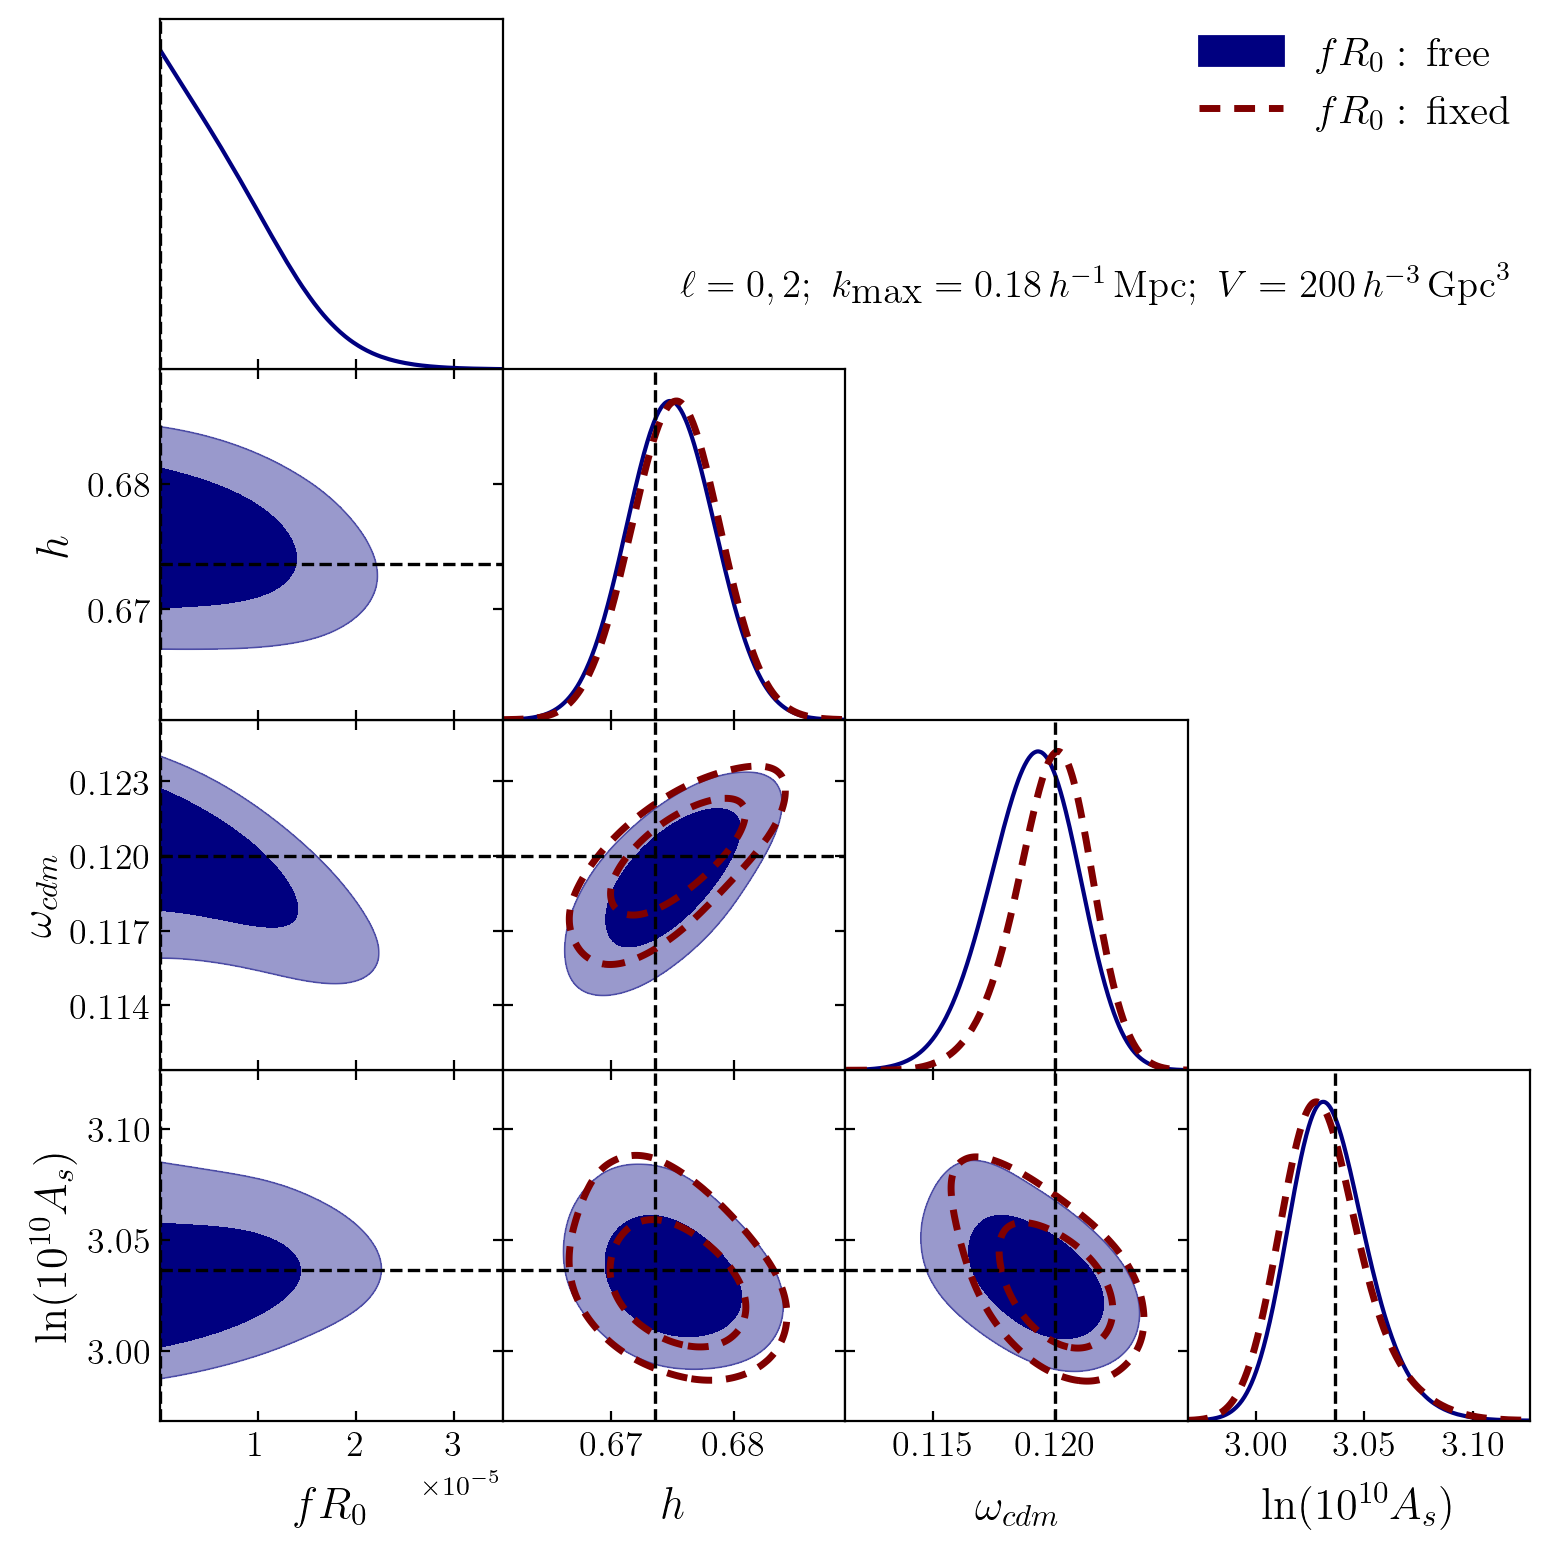

In [18]:
#samples = MCSamples(samples=chain_fkpt, names = labels_fkpt, ranges={r'$fR_0$':(0.0, None)})
#samples_smooth = samples.copy(settings={'mult_bias_correction_order':1,'smooth_scale_2D':0.7, 
#                       'smooth_scale_1D':0.7})

chains_and_labels = [
    (chain_free_new, labels_free),
    (chain_fixed_new, labels_fixed)
]

params_ranges = {
    r'$fR_0$': (0.0, None),
}

legend_labels = [r'$fR_0:\, \textnormal{free}$',
                 r'$fR_0:\, \textnormal{fixed}$']

filled = [True, False]
contour_ls = ['-', '--']
contour_lws = [1.5, 2.5]
contour_colors = ['navy', 'maroon']

params_to_show = [r'$fR_0$', r'$h$', r'$\omega_{cdm}$', r'$\ln(10^{10}A_s)$']

markers = {r'$fR_0$':0.0,
           r'$h$':0.6736, 
           r'$\omega_{cdm}$':0.12,
           #r'$\omega_{b}$':0.02237,
           #r'$\Omega_m$':(0.12 + 0.02237 + 0.00064420)/0.6736**2,
           r'$\ln(10^{10}A_s)$':np.log(10**10 * 2.0830e-9)}


plot_triangular_chains(chains_and_labels=chains_and_labels, 
                       filled=filled, contour_ls=contour_ls, contour_lws=contour_lws,
                       legend_labels=legend_labels, contour_colors=contour_colors, markers=markers,
                       params_to_show=params_to_show,
                       title=r'$\ell = 0,2;\, \, k_\textnormal{max} = 0.18\, h^{-1}\, \textnormal{Mpc};\,\, V = 200\, h^{-3}\, \textnormal{Gpc}^3$',
                       fontsize_title=14, title_x=0.7, title_y=0.82, 
                       save_path='fkpt_abacus.pdf', smoothing=True, params_ranges=params_ranges)


In [26]:
print(samples_smooth.getTable(limit=1).tableTex())

\begin{tabular} { l  c}

 Parameter &  68\% limits\\
\hline
{\boldmath$h$            } & $0.6748\pm 0.0035          $\\

{\boldmath$\omega_{cdm}$ } & $0.1190^{+0.0019}_{-0.0017}$\\

{\boldmath$\omega_b$     } & $0.02222\pm 0.00036        $\\

{\boldmath$\ln(10^{10}A_s)$} & $3.035^{+0.017}_{-0.020}   $\\

{\boldmath$fR_0$         } & $< 9.28\cdot 10^{-6}       $\\

{\boldmath$\Omega_m$     } & $0.3116^{+0.0031}_{-0.0028}$\\
\hline
\end{tabular}
